In [1]:
#------------------------------importing library---------------------------------------
from dateutil.parser import parse
import numpy as np
import pandas as pd
import pickle
from bpemb import BPEmb
import pytesseract
import cv2
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image
from bs4 import BeautifulSoup
import re
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
from torch.utils.data import Dataset 
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from scipy.sparse import csr_matrix
from torch_geometric.utils import convert

import torch.nn as nn
from timeit import default_timer as timer

import re

In [2]:
# -----------path to lapto -----------
text_path = "C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/*.txt"
img_path = "C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/*.jpg"
tesseract_path = 'C:/python_lib/ocr/tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = 'C:/python_lib/ocr/tesseract.exe'


# ----------------------------path to desktop ----------------------


# text_path= "C:/Users/sanjeev.br.kumar/Documents/Accenture_project/data/invoice_challenga_data/0325updated.task2train(626p)/*.txt"
# img_path= "C:/Users/sanjeev.br.kumar/Documents/Accenture_project/data/invoice_challenga_data/0325updated.task2train(626p)/*.jpg"
# tesseract_path ="C:/my_installation/treserect/tesseract.exe"
# pytesseract.pytesseract.tesseract_cmd ="C:/my_installation/treserect/tesseract.exe"
# data_path = "C:/Users/sanjeev.br.kumar/Documents/Accenture_project/save_data_code"

In [3]:
text_file = glob.glob(text_path)
img_file = glob.glob(img_path)

In [4]:
def SaveData(data,path):
    with open(path,'wb') as file:
        pickle.dump(data,file)

def LoadData(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
    
def displayColorImage(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("RGB Image")
    plt.axis('off')

def displayGrayImage(img):
    plt.imshow(img, cmap='gray')
    plt.title("Gray Image")
    plt.axis('off')
    
def display_image(img):
    res = isinstance(img, str)
    if res:
        print('reading image ../n' )
        img = cv2.imread(img)  
    if len(img.shape) > 2:
        plt.imshow(img, cmap='gray')
        plt.title("Image")
        plt.axis('off')
    else:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("RGB Image")
        plt.axis('off')


In [5]:
def get_ocr_text(img):  
    res = isinstance(img, str)
    if res:
        print('reading image ../n' )
        img = cv2.imread(img)  
    text = pytesseract.image_to_string(img)
#     print(text)
    return text

In [177]:
# read_data ()-> out data [image_list,ocr_text,out_text,file_name]
def read_data(img_path_list, text_path_list, data_no=150):
    img_list,ocr_text_list,text_list,file_name_list=[],[],[],[]
    j=0
    for i in range(data_no):
        img_path= img_path_list[i]
        img_name = img_path.split("\\")[-1]
        img_name = img_name.split(".jpg")[0]
        img_data = cv2.imread(img_path_list[i])
        img_list.append(img_data)
        ocr_text = get_ocr_text(img_path)
        ocr_text_list.append(ocr_text)
        text_path = text_path_list[j]
        text_name=text_path.split("\\")[-1]
        text_name = text_name.split('.txt')[0]
        while img_name != text_name:
            j +=1
            print('fileName is not same: ',img_name, text_name)
            text_path = text_path_list[j]
            text_name=text_path.split("\\")[-1]
            text_name = text_name.split('.txt')[0]
        with open(text_path, 'r') as file:
            text_data =file.read()
        text_list.append(eval(text_data))
        file_name_list.append(img_name)
#         data_list.append([img_data,ocr_text,eval(text_data),img_name])    
    return img_list,ocr_text_list,text_list,file_name_list


In [205]:
data = read_data(img_file,text_file,5)

reading image ../n
reading image ../n
fileName is not same:  X00016469619 X00016469612
reading image ../n
fileName is not same:  X00016469620 X00016469619
reading image ../n
fileName is not same:  X00016469622 X00016469620
reading image ../n
fileName is not same:  X00016469623 X00016469622


In [206]:
def create_input_output(input_data,output_data):
    in_list =[]
    out_list=[]
    is_list = isinstance(input_data, list)
    print('is_list : ',is_list)
    if not is_list:
        input_data = [input_data]
        output_data =[output_data]
    for i in range(len(input_data)):
        # input data prepration for requence generation 
        in_data = input_data[i].split() + ['<end>']
        in_data.insert(0, '<start>')
        in_list.append(in_data)
        
         # output data prepration for requence generation 
        out_data = []
        for k,v in output_data[i].items():
            temp=[]
            temp.append(k)
            temp.append(v.split())
            out_data.append(temp)
        out_list.append(out_data)
    if not is_list:
        return in_list[0],out_list[0]
    return in_list,out_list

In [208]:
input_data,output_data=create_input_output(data[1],data[2])
print(len(input_data)," ",len(output_data))

is_list :  True
5   5


In [209]:
print(input_data[0],'\n\n',output_data[0])

['<start>', 'tan', 'woon', 'yann', 'BOOK', 'TAK', '(TAMAN', 'DAYA)', 'SDN', 'BHD', 'B97', 'NO.5?', '55,57', '&', '59,', 'JALAN', 'SAGU', '18,', 'TAMAN', 'DAYA', '81100', 'JOHOR', 'BAHRU,', 'JOHOR.', 'WAM', 'MICA', 'A', 'Document', 'Ho', ':', 'TDO1167104', 'Date', '25/12/2018', '8:13:39', 'PM', 'Cashier', 'MANIS', 'Member', 'CASH', 'BILL', 'CODE/DESC', 'PRICE', 'Disc', 'AMOUITT', 'Quy', 'RM', 'RM', '9556939040118', 'KF', 'MODELLING', 'CLAY', 'KIDDY', 'FISH', '1PC', '*', '9.00)', '6,00', '9.00', 'Total', ':', '9,00', 'Rour', 'ding', 'Adjustment', '0.00', 'Round::d', 'Total', '(RM):', '9.60', 'Cash', 'CHANGE', 'GOODS', 'SOLD', 'ARE', 'NOT', 'RETURNAR', 'EXCHANGEABLE', 'THANK', 'YOU.', 'PLEASE', 'COME', 'AGA', 't', '<end>'] 

 [['company', ['BOOK', 'TA', '.K', '(TAMAN', 'DAYA)', 'SDN', 'BHD']], ['date', ['25/12/2018']], ['address', ['NO.53', '55,57', '&', '59,', 'JALAN', 'SAGU', '18,', 'TAMAN', 'DAYA,', '81100', 'JOHOR', 'BAHRU,', 'JOHOR.']], ['total', ['9.00']]]


In [227]:
#Creating the treaining sequence for lstm
def create_training_seq(input_data,output_data,batch=False):
    if not batch:
        input_data=[input_data]
        output_data=[output_data]
    X_list =[]  # for storing the list of input_data sequence
    y_list= []
    for i in range(len(input_data)):
#         print("\n-----------------------------loop ",i,"---------------------------------")
        in_data= input_data[i]
        out_data= output_data[i]
        in_list,out_list,temp_list,value_idx,idx =[],[],[],0,1
        while idx < len(in_data):
    #     for idx in range(1, len(in_data)):    # it will not increase index:  the error 
            temp_list =temp_list+[in_data[idx-1]]
            in_list.append(temp_list)
            text= in_data[idx]
#            uncomment below line to see output 
#             print('\n-->in_list : ',in_list[idx-1])
#             print('\n-->out_list : ',out_list)
#             print('idx : ',idx)
            if text == out_data[value_idx][1][0]:
                out_list.append(out_data[value_idx][0])
                j=0
#                 while in_data[idx] != out_data[value_idx][1][-1]:
                while j < len(out_data[value_idx][1]) and in_data[idx] != out_data[value_idx][1][-1]:
                    temp_list =temp_list+[in_data[idx]]
                    in_list.append(temp_list)
                    out_list.append(in_data[idx])  # todo what should be the output data actural data or extracted one (now). 
                    idx +=1
                    j +=1
#                     print('idx : ',idx)
                temp_list =temp_list+[in_data[idx]]
                in_list.append(temp_list)
                out_list.append(in_data[idx])
                value_idx +=1
            else:
                out_list.append('<nothing>')
    #         print('in_list : ',in_list[idx-1])
    #         print('out_list : ',out_list)
            idx +=1
#         print('idx : ',idx)
        X_list.append(in_list)
        y_list.append(out_list)
        
    if not batch:
        return X_list[0],y_list[0] 
        
    return X_list,y_list
            

In [228]:
X, y=create_training_seq(input_data,output_data,True)

In [219]:
print(input_data[1],"\n\n",output_data[1])

['<start>', 'tan', 'woon', 'yann', 'INDAH', 'GIFT', '&', 'HOME', 'BECO', '27,', 'JALAN', 'DEDAP', '13,', 'TANAN', 'JOHOR', 'JAYA,', '81100', 'JOHOR', 'BAHRU,', 'JOHOR.', 'Tel:07-3507405', 'Fax:07-3558160', 'RECEIPT', '19/10/2018', '20:49:59', '#01', 'Cashier:', 'CN', 'Location/SP:', '05', '/0531', 'MB:', '4026588', 'Room', 'No:', 'Of', '050100025279', 'Desc/Iten', 'Gty', 'Price', 'Amt/(RH)', 'ST-PRIVILEGE', 'CARD/GD', 'INDAH', '89888', '1', '10.00', '10.00', 'GF-TABLE', 'LAMP/STITCH', '<i>', '62483', '1', '55.90', '55.90', '@MIsc', '10.00%', 'HTotal', 'Qty', '2', 'TOTAL', 'AHT.', 'ROUNDING', 'ADI.', 'Thank', 'You', '!', 'Please', 'Come', 'Again', '!', 'Goods', 'Sold', 'Are', 'Not', 'Retui', 'Healing', 'In', 'Wholesale', 'And', 'fi', '<end>'] 

 [['company', ['INDAH', 'GIFT', '&', 'HOME', 'DECO']], ['date', ['19/10/2018']], ['address', ['27,', 'JALAN', 'DEDAP', '13,', 'TAMAN', 'JOHOR', 'JAYA,', '81100', 'JOHOR', 'BAHRU,', 'JOHOR.']], ['total', ['60.30']]]


In [196]:
len(X),len(y)

(4, 4)

In [65]:
def create_out(data):

    
    out_data = []
    for k,v in data.items():
        temp=[]
#         out_data= out_data+[k]+v.split()
        temp.append(k)
        temp.append(v.split())
        out_data.append(temp)
    return out_data
out_data =create_out(data[0][2])
print(out_data)

[['company', ['BOOK', 'TA', '.K', '(TAMAN', 'DAYA)', 'SDN', 'BHD']], ['date', ['25/12/2018']], ['address', ['NO.53', '55,57', '&', '59,', 'JALAN', 'SAGU', '18,', 'TAMAN', 'DAYA,', '81100', 'JOHOR', 'BAHRU,', 'JOHOR.']], ['total', ['9.00']]]


In [31]:
def create_input_output_data(data):
    in_list =[]
#     out_list =[]
#     prev_list=[]
#     prev_list.append(data[0])
    temp_list=[]
    for idx,text in enumerate(data):
        temp_list =temp_list+[text]
        in_list.append(temp_list)
    return in_list


In [57]:
out_data =''.join([k+' '+v for k,v in data[0][2].items()]).split()

<IPython.core.display.Javascript object>


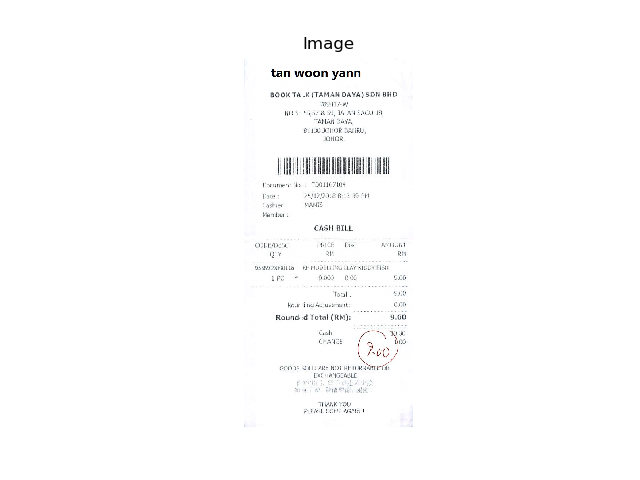

In [81]:
display_image(data[0][0])

In [82]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 